In [ ]:
#google colab drive mount code

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
import re

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import StandardScaler

stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from gensim.models import Word2Vec

from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Data Read

real_news = pd.read_csv('/content/gdrive/My Drive/Fake News/Model/Data/True.csv')
fake_news = pd.read_csv('/content/gdrive/My Drive/Fake News/Model/Data/Fake.csv')

In [ ]:
# Getting the shape of real news data
real_news.shape

(21417, 4)

In [ ]:
fake_news.shape

(23481, 4)

In [ ]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
real_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


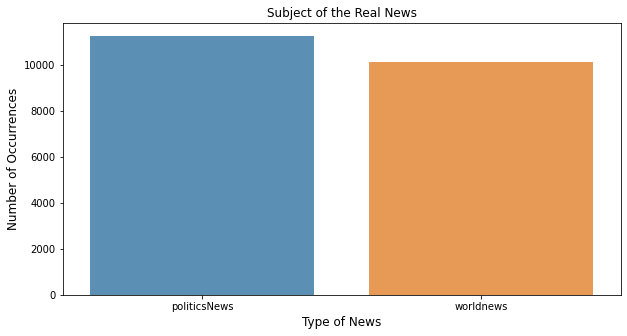

In [ ]:
real_subject_count=real_news['subject'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=real_subject_count.index, y=real_subject_count.values, alpha = 0.8)
# sns.barplot(real_subject_count.index, real_subject_count.values, alpha=0.8)
plt.title('Subject of the Real News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

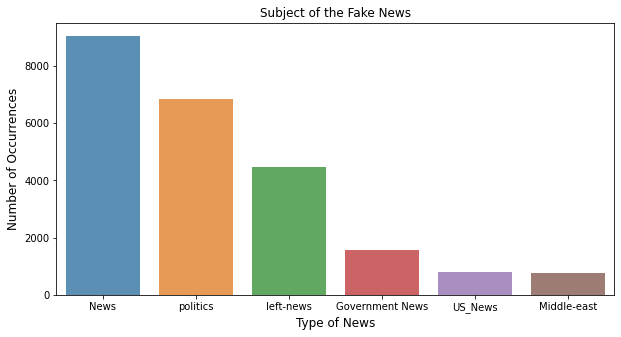

In [ ]:
fake_subject_count=fake_news.subject.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x= fake_subject_count.index, y = fake_subject_count.values, alpha=0.8)
plt.title('Subject of the Fake News')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of News', fontsize=12)
plt.show()

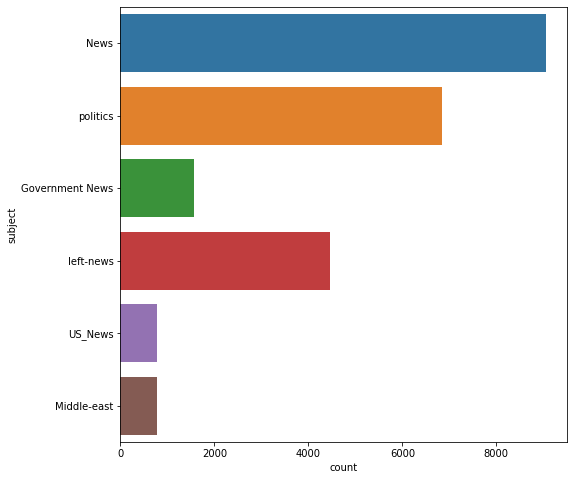

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = fake_news)

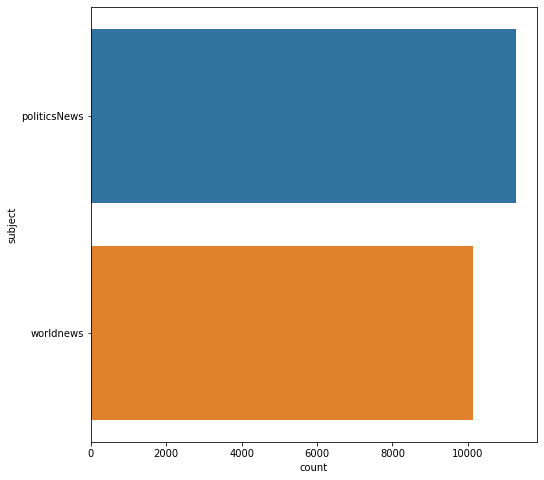

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject', data = real_news)

In [ ]:
# Getting the data having politics as subject

real_news1=real_news[real_news['subject']=='politicsNews']
fake_news1=fake_news[fake_news['subject'].isin(['politics','Government News', 'US_News'])].reset_index(drop=True)

In [ ]:
fake_news1.subject.value_counts(), real_news1.subject.value_counts()

(politics           6841
 Government News    1570
 US_News             783
 Name: subject, dtype: int64, politicsNews    11272
 Name: subject, dtype: int64)

In [ ]:
# checking if there is empty rows in real news
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 1


,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [ ]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake_news1.iloc[empty_fake_index].tail()

No of empty rows: 480


,title,text,subject,date
8312,(VIDEO)MILWAUKEE SHERIFF DAVID CLARKE HAMMERS ...,,Government News,"May 8, 2015"
8323,BLACK REPUBLICAN AND BRILLIANT NEUROSURGEON AN...,,Government News,"May 5, 2015"
8325,(VIDEO)INCREDIBLE ACCOUNT FROM SHERIFF MICHAEL...,,Government News,"May 4, 2015"
8337,(VIDEO) RIOTERS TAKE SELFIES WITH TORCHED POLI...,,Government News,"Apr 27, 2015"
8368,TREY GOWDY TO DEA CHIEF ON MISCONDUCT: “WHAT T...,,Government News,"Apr 14, 2015"


In [ ]:
# since it is only one row we can remove it
# dropping this row in real set
real_news1 = real_news1.drop(8970, axis=0)

In [ ]:
empty_real_index = [index for index,text in enumerate(real_news1.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_real_index)}")
real_news1.iloc[empty_real_index].tail()

No of empty rows: 0


,title,text,subject,date


In [ ]:
# Get the substring in pandas 
# getting a the source from each text 
real_news1['source'] =real_news1.text.str.slice(10, 20)
print(real_news1)

                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
11267  Obama says willing to work with Republican Spe...   
11268  Obama says Islamic State fight far from 'World...   
11269  Chelsea Clinton stands her mother's ground in ...   
11270  Obama jokes about a Trump State of the Union a...   
11271  Clinton expands on plan to tax wealthy as Sand...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

In [ ]:
real_news1.source.value_counts()

 (Reuters)    5939
Reuters) -     768
euters) -      388
(Reuters)      206
uters) - T     129
              ... 
- The FBI        1
- A Virgin       1
- Burlingt       1
/MARIETTA,       1
ters) - If       1
Name: source, Length: 1217, dtype: int64

In [ ]:
real_news1.subject.value_counts()

politicsNews    11271
Name: subject, dtype: int64

In [ ]:
#creating label for fake and real news
real_news1['label']=1
fake_news1['label']=0

In [ ]:
real_news1.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [ ]:
fake_news1.head()

,title,text,subject,date,label
0,Democrat Senator Warns Mueller Not To Release ...,"According to The Hill, Democrat Senator Bob Ca...",politics,19-Feb-18,0
1,MSNBC ANCHOR Flabbergasted at What Texas Teach...,If we protect every other government building ...,politics,19-Feb-18,0
2,WATCH: SNOWFLAKES ASKED Communist Party Platfo...,Ami Horowitz is fantastic! Check out this man ...,politics,19-Feb-18,0
3,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Just one more reminder of why President Trump ...,politics,18-Feb-18,0
4,DOJ’s JEFF SESSIONS Opens Investigation Into W...,Thank goodnesss Jeff Sessions is moving on fin...,politics,18-Feb-18,0


In [ ]:
fake_news1['title'][1]

'MSNBC ANCHOR Flabbergasted at What Texas Teachers Do to Protect Their Students [Video]'

In [ ]:
fake_news1['text'][1]

'If we protect every other government building or public venue with armed guards, why shouldn t our schools be protected with armed teachers? A Texas Sheriff shocked an MSNBC host when he discussed how he prepares local teachers to be armed in the classroom. common sense solution? You betcha!Sheriff Paul Cairney of Argyle, Texas, described the process by which staff members can carry firearms in the school district. The Sheriff said that the staff at the school who choose to carry a firearm go through an intense round of interviews and training before they are allowed to carry on campus. The MSNBC host was flabbergasted at the practice and asked the Sheriff about concerns for the safety of the students in the school when there are firearms around.Sheriff Cairney:  The time to do nothing is over THE PROCESS TO BECOME A SCHOOL MARSHALL:To become a school marshal, those employees must undergo extensive active shooter and firearms training with the state. They must also undergo a mental he

In [ ]:
#Appending the two dataframe
news_df = real_news1.append(fake_news1, ignore_index=True)

In [ ]:
news_df.shape

(20465, 6)

In [ ]:
news_df.head()

,title,text,subject,date,source,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",(Reuters),1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",(Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",(Reuters),1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",(Reuters),1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",SHINGTON (,1


In [ ]:
# Shuffle Data
from sklearn.utils import shuffle
news_df = shuffle(news_df)
news_df = news_df.reset_index(drop=True)
news_df

,title,text,subject,date,source,label
0,Congressman will not seek relection amid misco...,WASHINGTON (Reuters) - U.S. Representative Rub...,politicsNews,"December 16, 2017",(Reuters),1
1,U.S. plans to curb tax 'inversions' could hit ...,LONDON (Reuters) - Planned changes that Presid...,politicsNews,"April 11, 2016",uters) - P,1
2,Pennsylvania Democrats raise concerns over CP'...,CHICAGO (Reuters) - Democrats from Pennsylvani...,politicsNews,"February 1, 2016",euters) -,1
3,EXPLODING AFRICAN REFUGEE POPULATION STRESSING...,It s not just the our open southern borders we...,politics,"Jul 13, 2015",NaN,0
4,Not over yet: Reid cautions Democrats relishin...,"WASHINGTON (Reuters) - For some Democrats, Don...",politicsNews,"May 5, 2016",(Reuters),1
...,...,...,...,...,...,...
20460,Trump believes Roy Moore should step aside if ...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"November 16, 2017",(Reuters),1
20461,U.S. aerospace industry urges Trump to help Ex...,WASHINGTON (Reuters) - The chief executive of ...,politicsNews,"December 6, 2016",(Reuters),1
20462,Exclusive: Billionaire Republican donors urge ...,NEW YORK (Reuters) - A group of at least six w...,politicsNews,"July 28, 2016",Reuters) -,1
20463,"Trump says unnamed country plans to build, exp...",INDIANAPOLIS (Reuters) - President Donald Trum...,politicsNews,"September 27, 2017",IS (Reuter,1


In [ ]:
# spliting data into 80% training set and 20% testing set.
from sklearn.model_selection import train_test_split

train, test = train_test_split(news_df, test_size=0.2)


In [ ]:
train.shape


(16372, 6)

In [ ]:
test.shape

(4093, 6)

In [ ]:
news_df_train = train

In [ ]:
news_df_train.head()


,title,text,subject,date,source,label
14330,BREAKING NEWS: REINCE PRIEBUS GONE! Trump Twee...,Establishment Republican Reince Priebus is gon...,politics,"Jul 28, 2017",NaN,0
6093,FBI REDUX: What’s Behind New Probe into Hillar...,21st Century Wire says In a stunning turn of e...,US_News,"October 28, 2016",NaN,0
5303,BREAKING: REPORTER Says Secret Service Took De...,Health professionals have been speculating for...,politics,"Oct 10, 2016",NaN,0
336,REPORT: FBI DIRECTOR COMEY Blocked By Obama Ad...,Comey would likely have pitched the op-ed to T...,Government News,"Mar 30, 2017",NaN,0
10579,"Atlantic City, N.J., emergency manager suggest...","(Reuters) - Atlantic City, the distressed New ...",politicsNews,"January 16, 2016",- Atlantic,1


In [ ]:
# print(news_df_train['title'])

In [ ]:
news_df_train.shape

(16372, 6)

subject
Government News    1232
US_News             630
politics           5494
politicsNews       9016
Name: text, dtype: int64


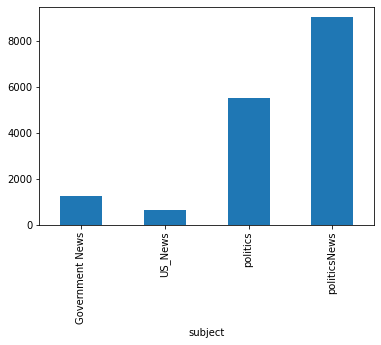

In [ ]:
# To show how many articles per subject:
print(news_df_train.groupby(['subject'])['text'].count())
news_df_train.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
0    7356
1    9016
Name: text, dtype: int64


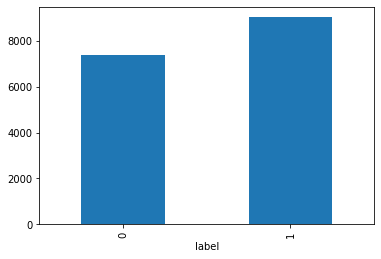

In [ ]:
print(news_df_train.groupby(['label'])['text'].count())
news_df_train.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

1    9016
0    7356
Name: label, dtype: int64


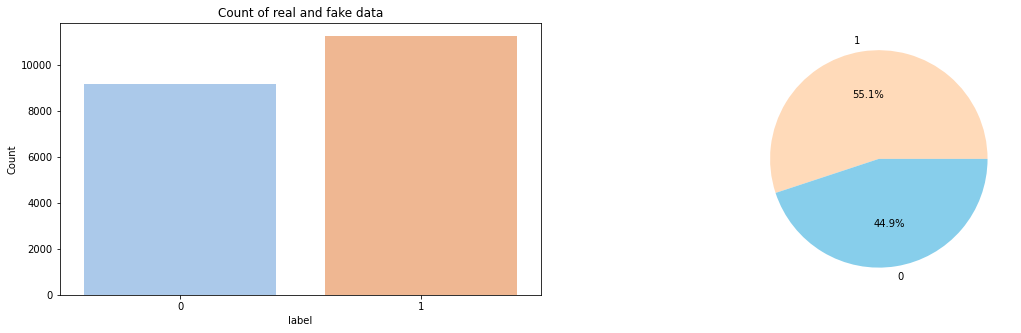

In [ ]:
print(news_df_train["label"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(news_df.label,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("label")
g2 = plt.pie(news_df_train["label"].value_counts().values,explode=[0,0],labels=news_df_train.label.value_counts().index, autopct='%1.1f%%',colors=['PeachPuff', 'SkyBlue'])
fig.show()

In [ ]:
# Downloading dictionaries
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train_data = np.asarray(list(news_df_train['title']))




In [ ]:
# creating corpus words.
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
corpus_words = []
for i in range(0,len(train_data)):
    message = re.sub('[^a-zA-Z0-9]', ' ', train_data[i])
    message = message.lower()
    message = word_tokenize(message)
    message = [lemmatizer.lemmatize(w) for w in message if not w in stopwords.words('english')]
    message = ' '.join(message)
    corpus_words.append(message)
print(corpus_words)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['breaking news reince priebus gone trump tweet replacement', 'fbi redux behind new probe hillary clinton email', 'breaking reporter say secret service took debate attendee phone avoid flash could trigger hillary seizure video', 'report fbi director comey blocked obama administration last summer supposed russian influence 2016 election', 'atlantic city n j emergency manager suggests privatizing fire department', 'syria north korea tillerson would inherit messy global situation', 'watch donald discus military fl rally see beating rubio bush home state', 'harry harry crowd yell military hero name president trump incredible speech veteran video', 'lock clinton foundation investigation moving forward', 'whoa mainstream medium officially declared war crooked hillary far away devastating 10 minute hillary clinton ever see video', 'democrat search answer stem spreading republican tide', 'hysterical hillary yelling campaign trail', 'violent antifa thug wear mask hide identity let make sure eve

In [ ]:
# Defining TF-IDF vectorization of words.
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectirization = TfidfVectorizer(max_features=1000)
X = tf_idf_vectirization.fit_transform(corpus_words).toarray()
print("x looks like:",X)

x looks like: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Feature scaling of X.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("after scaling x will be:",X)

after scaling x will be: [[-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]
 [-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]
 [-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]
 ...
 [-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]
 [-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]
 [-0.07010026 -0.06330881 -0.05101321 ... -0.05471211 -0.06373365
  -0.04959668]]


In [ ]:
# Performing PCA on X

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

print(pca_result)

pca_file = 'fake_news_pca_result.csv'
pd.DataFrame(pca_result).to_csv(pca_file)

[[ 1.41240707  0.08112948]
 [ 1.03906992 -1.01526214]
 [ 1.86048425 -0.30294556]
 ...
 [ 0.26363502  0.02433308]
 [ 0.96413516 -0.15577319]
 [ 1.07470756 -0.20704933]]


In [ ]:
# Defining K means clustering
from sklearn import cluster
Kmeans = cluster.KMeans(n_clusters=2,init='k-means++',max_iter=500,verbose=True,random_state=0)
clustered = Kmeans.fit_predict(pca_result)

Initialization complete
Iteration 0, inertia 64227.04430753224
Iteration 1, inertia 61244.51893626235
Iteration 2, inertia 61128.140899756996
Iteration 3, inertia 61126.772735907274
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 189415.10773876042
Iteration 1, inertia 61270.07335732818
Iteration 2, inertia 61128.140899756996
Iteration 3, inertia 61126.772735907274
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 103934.82089231133
Iteration 1, inertia 61154.45403011164
Iteration 2, inertia 61126.772735907274
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 63205.22111998402
Iteration 1, inertia 59424.60460444342
Iteration 2, inertia 59226.68309970815
Iteration 3, inertia 59176.68766464057
Iteration 4, inertia 59166.02040043491
Iteration 5, inertia 59157.07444523682
Iteration 6, inertia 59144.34153358528
Iteration 7, inertia 58922.069724028
Iteration 8, inertia

In [ ]:
# creating dataframe with predicted clusters

predicted_dataframe = news_df_train.copy()
predicted_dataframe['Prediction'] = clustered

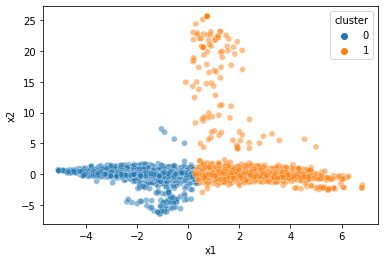

In [ ]:
# plotting scatterplot for K-Means clustering
import matplotlib.pyplot as plt
pca_dataframe = pd.DataFrame(pca_result)
pca_dataframe['cluster'] = clustered
pca_dataframe.columns = ['x1','x2','cluster']
k_means_figure = sns.scatterplot(data=pca_dataframe,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5)
figure = k_means_figure.get_figure()
figure.savefig('fake_news_K_Means_Clustering_figure')
plt.show()


In [ ]:
# saving the model
import pickle
Kmeans = Kmeans.fit(pca_result)
file_name = 'fake_news_classifier_KMeans.sav'
pickle.dump(Kmeans, open(file_name, 'wb'))

Initialization complete
Iteration 0, inertia 64227.04430753224
Iteration 1, inertia 61244.51893626235
Iteration 2, inertia 61128.140899756996
Iteration 3, inertia 61126.772735907274
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 189415.10773876042
Iteration 1, inertia 61270.07335732818
Iteration 2, inertia 61128.140899756996
Iteration 3, inertia 61126.772735907274
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 103934.82089231133
Iteration 1, inertia 61154.45403011164
Iteration 2, inertia 61126.772735907274
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 63205.22111998402
Iteration 1, inertia 59424.60460444342
Iteration 2, inertia 59226.68309970815
Iteration 3, inertia 59176.68766464057
Iteration 4, inertia 59166.02040043491
Iteration 5, inertia 59157.07444523682
Iteration 6, inertia 59144.34153358528
Iteration 7, inertia 58922.069724028
Iteration 8, inertia